In [1]:
## Standard libraries
from PIL import Image
import numpy as np
import cv2

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision import transforms

## EuroSAT and ViT
from model import VisionTransformer, img_to_patch
from dataset import EuroSAT, random_split
from predict import get_transform_EuroSAT

/Users/TemporaryAdmin/Documents/MLSI/ViT/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATCH_SIZE = 4
MODEL_DIR = f'../weights_image_64_patch_size_{PATCH_SIZE}/best.pt'

In [3]:
patch_size = PATCH_SIZE

In [4]:
# Get the test set
tr = get_transform_EuroSAT()
dataset = EuroSAT(transform=tr)
trainval, _ = random_split(dataset, 0.9, random_state=42)
_, test_ds = random_split(trainval, 0.9, random_state=7)

# Visualize some examples
NUM_IMAGES = 4
EuroSAT_images = torch.stack([test_ds[idx][0] for idx in range(NUM_IMAGES)], dim=0)
EuroSAT_images.shape # B:patch_size, C:channels, H, W = x.shape

torch.Size([4, 3, 64, 64])

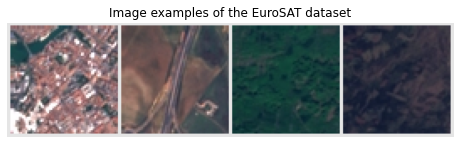

In [5]:
img_grid = torchvision.utils.make_grid(EuroSAT_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the EuroSAT dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

As a preprocessing step, we split an image of, for example,  pixels into 64 patches. Each of those patches is considered to be a “word”/”token” and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task.

For our images of size, we choose a patch size of 4. Hence, we obtain sequences of 64 patches of size. We visualize them below:

In [6]:
img_patches = img_to_patch(EuroSAT_images, patch_size=4) # Flatten: [B, H'*W', C*p_H*p_W] = [4, 4x64, 3x4x4]
img_patches.shape

torch.Size([4, 256, 48])

In [7]:
B, T, _ = img_patches.shape
B, T

(4, 256)

In [8]:
from torch import nn

In [11]:
num_channels = 3
embed_dim = 256
input_layer = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
input_layer

Linear(in_features=768, out_features=256, bias=True)

In [12]:
x = input_layer(img_patches)
x

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x48 and 768x256)

In [ ]:
x.shape

In [ ]:
img_patches

In [ ]:
img_patches = img_to_patch(EuroSAT_images, patch_size=4, flatten_channels=False)
img_patches.shape

In [ ]:
EuroSAT_images.shape[0]

In [ ]:
fig, ax = plt.subplots(EuroSAT_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(EuroSAT_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [ ]:
img_patches = img_to_patch(EuroSAT_images, patch_size=4)
img_patches.shape

In [ ]:
from torch import nn

In [ ]:
im = img_patches #[1]
im.shape

In [ ]:
embed_dim = 256
patch_size = 4
num_channels = 3  # Bands
ln = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
ln(im).shape

In [ ]:
cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
B = 64
_cls_token = cls_token.repeat(B, 1, 1)
x = torch.cat([_cls_token, ln], dim=1)

In [ ]:
cls_token.shape

In [ ]:
save = torch.load(MODEL_DIR, map_location='cpu')
normalization = save['normalization']
model = VisionTransformer(embed_dim=256, hidden_dim=512, num_heads=8, num_layers=6, patch_size=4, num_channels=3,
                          num_patches=64, num_classes=10, dropout=0.2)
model.load_state_dict(save['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()

tr = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(**normalization)])
# tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize(**normalization)])

x = tr(im)
x.size()

In [ ]:
x

In [ ]:
x.unsqueeze(0)

In [ ]:
x.unsqueeze(0).size()

In [ ]:
logits, att_mat = model(x.unsqueeze(0))
att_mat

In [ ]:
len(att_mat)

In [ ]:
att_mat[5].size()

In [ ]:
torch.stack(att_mat).size()

In [ ]:
torch.stack(att_mat).squeeze(1).size()

In [ ]:
att_mat2 = torch.stack(att_mat).squeeze(1)
att_mat2

In [ ]:
att_mat2.size()

In [ ]:
att_mat3 = torch.mean(att_mat2, dim=1)
att_mat3

In [ ]:
att_mat3.size()

In [ ]:
att_mat3.size(1)

In [ ]:
residual_att = torch.eye(att_mat3.size(1))
residual_att

In [ ]:
residual_att.size()

In [ ]:
att_mat3 + residual_att

In [ ]:
aug_att_mat = att_mat3 + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
aug_att_mat

In [ ]:
aug_att_mat.size()

In [ ]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

In [ ]:
joint_attentions.size()

In [ ]:
aug_att_mat.size()

In [ ]:
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

In [ ]:
joint_attentions.size()

In [ ]:
joint_attentions

In [ ]:
v = joint_attentions[-1]
v

In [ ]:
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
grid_size

In [ ]:
v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

In [ ]:
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")
result

In [ ]:
im

In [ ]:
EuroSAT_labels = dict(enumerate(open('data/EuroSATLabels.txt')))

In [ ]:
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {EuroSAT_labels[idx.item()]}', end='')

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

In [ ]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(result)
